### Import

In [1]:
import keras
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import shutil
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

In [2]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чистим папку, если чт-то пошло не так
shutil.rmtree('/content/drive/MyDrive/course_work_nn/train')

### Preparing data

In [ ]:
!cd /content/drive/MyDrive/course_work_nn && unzip -q train.zip

In [3]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [ ]:
df.shape

(50046, 3)

### Unbalanced classes

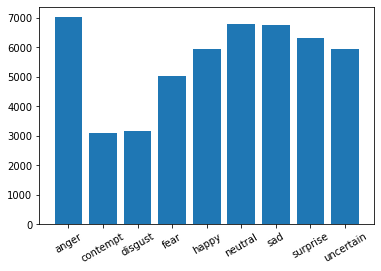

In [ ]:
df2 = df[['Unnamed: 0','emotion']].groupby('emotion').agg('count')
plt.bar(df2.index, df2['Unnamed: 0'])
plt.xticks(rotation=30)
plt.show()

In [4]:
# преобразуем имена файлов(убрать все кроме имени)
for i in range(len(df)):  
    df['image_path'][i] = df['image_path'][i].replace("./train/", "")

<ipython-input-4-edeccec4a1a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'][i] = df['image_path'][i].replace("./train/", "")


Веса для классов

In [5]:
class_weight = {}
for i, j  in enumerate(set(df.emotion)):
    count_of_samples = df[df['emotion'] == j].agg('count')[0]
    total = df.shape[0]
    weight = (1 / count_of_samples) * (total / 9.0)

    class_weight[i] = weight

In [ ]:
class_weight

{0: 0.8183468236448369,
 1: 1.1024319323288396,
 2: 0.938192452617963,
 3: 0.825024727992087,
 4: 1.8024851431658562,
 5: 0.8794348674152566,
 6: 0.7918921484857117,
 7: 0.933781136300028,
 8: 1.7624933967247756}

Разбиваем на тренировочные и валидационные данные, стратифицируем по классам.

In [6]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,0:2], df['emotion'], test_size=0.2, stratify=df['emotion'])

In [7]:
train = pd.concat([train_x, train_y], axis = 1).reset_index(drop=True)
test = pd.concat([test_x, test_y], axis = 1).reset_index(drop=True)

Делаем one-hot encoding

In [8]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(train.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_train = pd.concat([train, tmp], axis = 1)

In [9]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(test.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_test = pd.concat([test, tmp], axis = 1)

In [ ]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']

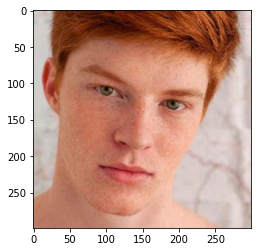

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/course_work_nn/train/anger/1000.jpg')
plt.imshow(img)

### ImageDataGenerator

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,                                             
                                                batch_size=128)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True, 
                                                batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


### Model

In [182]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))


In [77]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 128)     

In [183]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [79]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main11.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

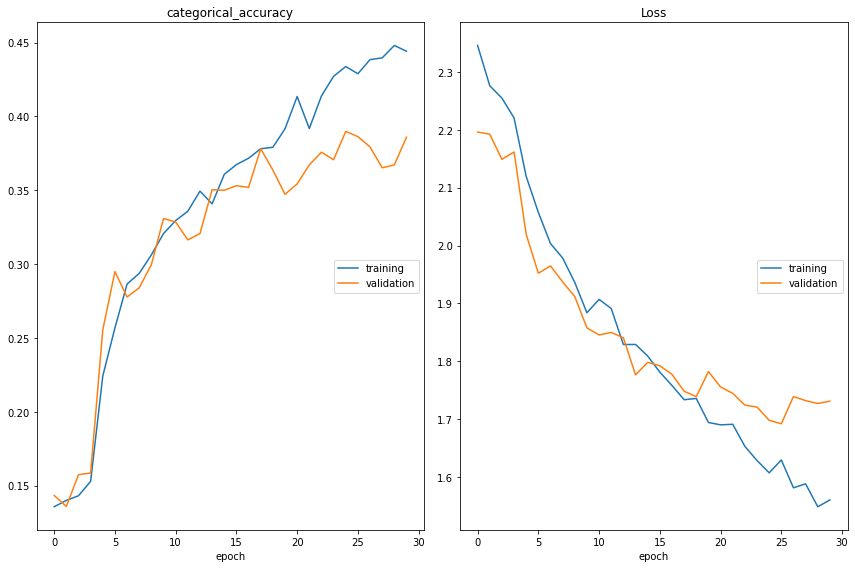

categorical_accuracy
	training         	 (min:    0.136, max:    0.448, cur:    0.444)
	validation       	 (min:    0.136, max:    0.390, cur:    0.386)
Loss
	training         	 (min:    1.548, max:    2.346, cur:    1.560)
	validation       	 (min:    1.692, max:    2.196, cur:    1.731)
40/40 [==============================] - 159s 4s/step - loss: 1.5601 - categorical_accuracy: 0.4441 - val_loss: 1.7310 - val_categorical_accuracy: 0.3859


In [80]:
history = model.fit( train_generator_1,
                      steps_per_epoch=40,
                      epochs = 30,
                       validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### Trying to use regularization to force network learning after 0.35 accuracy

In [26]:
model01 = models.Sequential()

model01.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,3)))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.Flatten())
model01.add(tf.keras.layers.Dense(256, 
                                kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                activity_regularizer=regularizers.L2(1e-4), 
                                activation = 'relu'))
model01.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [27]:
model01.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [28]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath = 'model_main01_reg.h5', 
                monitor = 'val_categorical_accuracy', 
                save_best_only = True,)

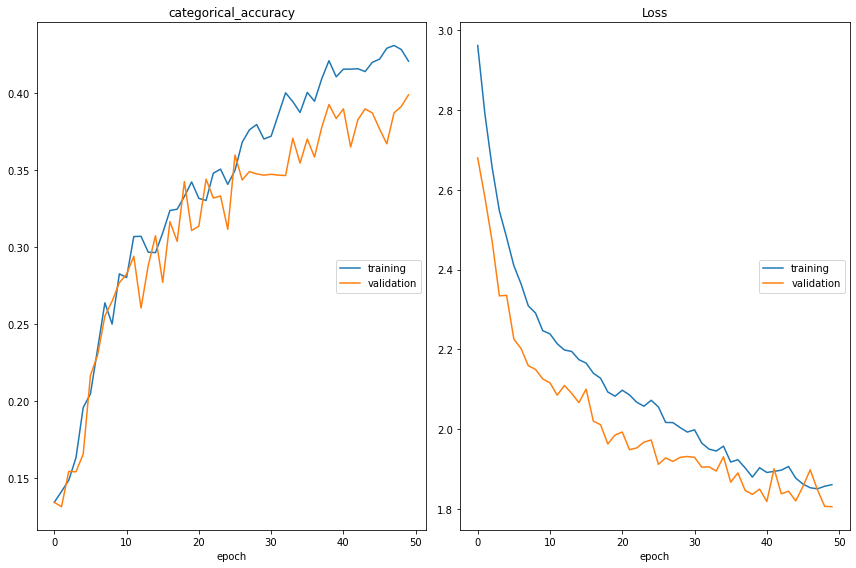

categorical_accuracy
	training         	 (min:    0.134, max:    0.431, cur:    0.421)
	validation       	 (min:    0.132, max:    0.399, cur:    0.399)
Loss
	training         	 (min:    1.851, max:    2.962, cur:    1.861)
	validation       	 (min:    1.806, max:    2.680, cur:    1.806)
30/30 [==============================] - 122s 4s/step - loss: 1.8614 - categorical_accuracy: 0.4206 - val_loss: 1.8061 - val_categorical_accuracy: 0.3987


In [29]:
history = model01.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 50,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), model_checkpoint_callback],
                      class_weight=class_weight)

### The second variant of model

In [21]:
model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape = (128,128,3))) 
model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(256, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.1))
model1.add(tf.keras.layers.Dense(9, activation='softmax'))


In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [22]:
model1.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [23]:
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main12.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

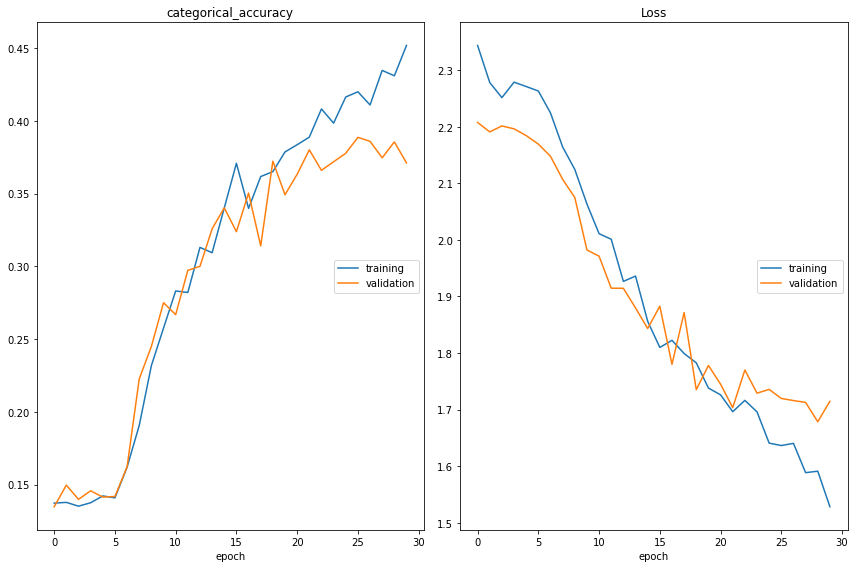

categorical_accuracy
	training         	 (min:    0.135, max:    0.452, cur:    0.452)
	validation       	 (min:    0.135, max:    0.389, cur:    0.371)
Loss
	training         	 (min:    1.529, max:    2.344, cur:    1.529)
	validation       	 (min:    1.679, max:    2.207, cur:    1.715)
30/30 [==============================] - 282s 9s/step - loss: 1.5285 - categorical_accuracy: 0.4518 - val_loss: 1.7149 - val_categorical_accuracy: 0.3711


In [24]:
history = model1.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 30,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), model_checkpoint_callback2],
                      class_weight=class_weight)

### The second model with regularization

In [34]:
model02 = tf.keras.Sequential()

model02.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape = (128,128,3))) 
model02.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model02.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model02.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model02.add(tf.keras.layers.Flatten())
model02.add(tf.keras.layers.Dense(256, kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                activity_regularizer=regularizers.L2(1e-4),
                                activation='relu'))
model02.add(tf.keras.layers.Dropout(0.1))
model02.add(tf.keras.layers.Dense(9, activation='softmax'))


In [35]:
model02.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main02_reg.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

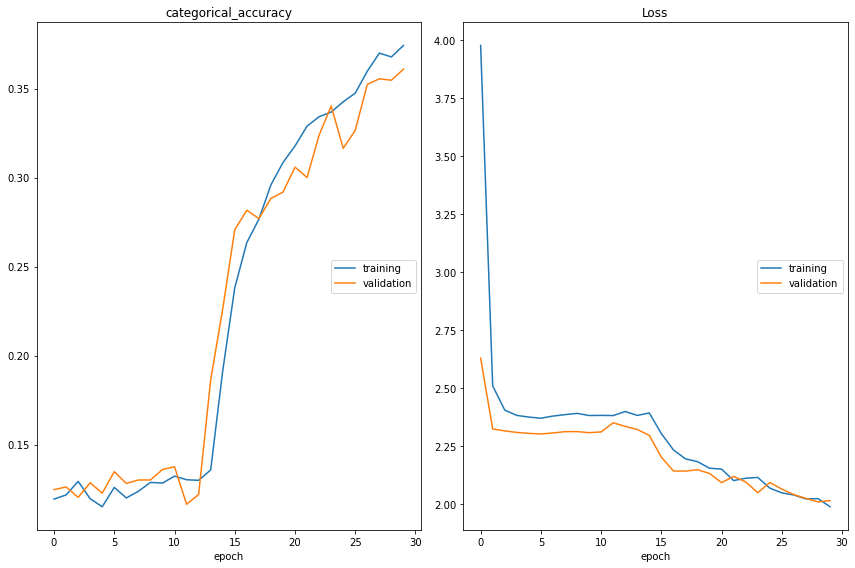

categorical_accuracy
	training         	 (min:    0.115, max:    0.374, cur:    0.374)
	validation       	 (min:    0.116, max:    0.361, cur:    0.361)
Loss
	training         	 (min:    1.988, max:    3.975, cur:    1.988)
	validation       	 (min:    2.009, max:    2.628, cur:    2.015)
40/40 [==============================] - 363s 9s/step - loss: 1.9885 - categorical_accuracy: 0.3742 - val_loss: 2.0150 - val_categorical_accuracy: 0.3609


In [37]:
history = model02.fit( train_generator_1,
                      steps_per_epoch=40,
                      epochs = 30,
                       validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

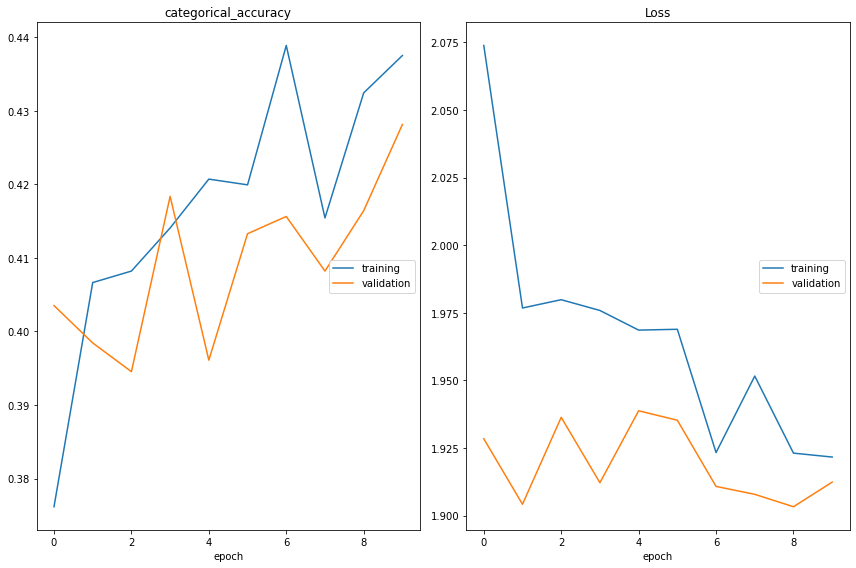

categorical_accuracy
	training         	 (min:    0.376, max:    0.439, cur:    0.438)
	validation       	 (min:    0.395, max:    0.428, cur:    0.428)
Loss
	training         	 (min:    1.922, max:    2.074, cur:    1.922)
	validation       	 (min:    1.903, max:    1.939, cur:    1.912)
40/40 [==============================] - 385s 10s/step - loss: 1.9216 - categorical_accuracy: 0.4375 - val_loss: 1.9124 - val_categorical_accuracy: 0.4281


In [16]:
history = model02.fit( train_generator_1,
                      steps_per_epoch=40,
                      epochs = 10,
                       validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### Vizualization

In [ ]:
def show_pred(images, labels, predicted_labels=None):
    plt.figure(figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = image.load_img(images[i])
        plt.imshow(img)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

157/157 [==============================] - 84s 535ms/step


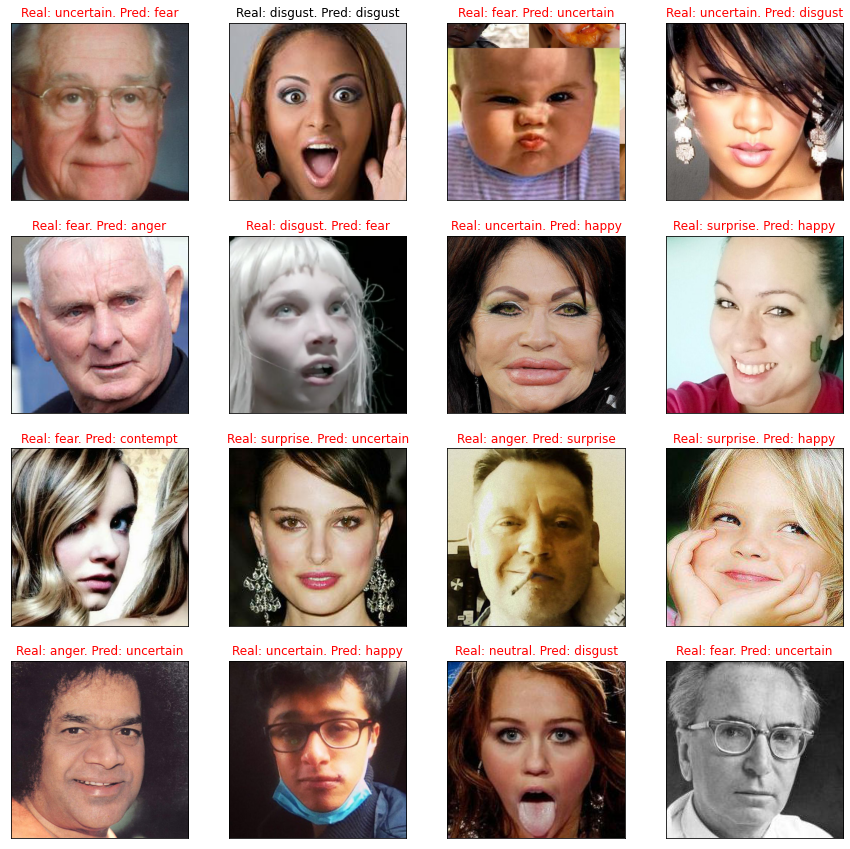

In [ ]:
predicted_labels = model.predict(test_generator_1)
idxs = np.random.choice(np.arange(len(test_generator_1.filenames)), 16, replace=False)
fnames = []
labels = []
preds = []
for i in idxs:
  fnames.append('/content/drive/MyDrive/course_work_nn/train/' + test_generator_1.filenames[i])
  labels.append(list(set(df['emotion']))[test_generator_1.labels[i]])
  preds.append(list(set(df['emotion']))[np.argmax(predicted_labels[i])])
show_pred(fnames, labels, preds)

### File for Kaggle

In [ ]:
!cd /content/drive/MyDrive/course_work_nn/test_kaggle && unzip -q test_kaggle.zip

In [ ]:
# shutil.rmtree('/content/drive/MyDrive/course_work_nn/test_kaggle')

In [152]:
datagen = ImageDataGenerator(rescale = 1/255.)

In [176]:
test_generator = datagen.flow_from_directory(directory = 'test_kaggle/test_kaggle/',
                                       target_size=(128,128),
                                       class_mode='categorical',
                                       classes=['.'],
                                       shuffle = False,
                                       batch_size=1)

Found 5000 images belonging to 1 classes.


In [23]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']

In [177]:
model01 = tf.keras.models.load_model('model_main02_reg.h5')

In [179]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator_1.reset()
pred=model01.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

predictions = []
for i in pred:
    predictions.append(emotions[np.argmax(i)])

filenames = []
for i in test_generator.filenames:
    filn = i.replace(".\\",'')
    filenames.append(filn)

results=pd.DataFrame({"image_path":filenames,
                      "emotion":predictions})

5000/5000 [==============================] - 160s 32ms/step


In [180]:
results.to_csv('model_02_test.csv', index=False)